# v0.2 - Exp5
Same as Exp3 (5e) but 15e

In [1]:
from fastai2.text.all import *
from fastai2.callback.all import *
from fastai2.basics import *
import seaborn as sns

from nlp import load_dataset

from einops import rearrange
import gc
import csv

In [2]:
path = Path('data/irish/parallel_corpora/paracrawl')
fn = 'para_crawl_huggingface_clean_v02_20200723.csv'

### Load saved dataset

In [3]:
df=pd.read_csv(path/fn)
print(len(df))
df.head()

357399


,en,ga,clean
0,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True
1,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",True
2,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True
3,"As you can see, so get to show off the spacious shapes in 3D (red and blue).","Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",True
4,"Equation Solving – Traditional, simple","Ligningsløsning – Traidisiúnta, simplí",True


# RAISE BUG

In [4]:
path = Path('data/irish/parallel_corpora/paracrawl')
fn = 'para_crawl_huggingface_clean_v02_20200723.csv'

In [5]:
# ds_dict = load_dataset('csv', data_files=str(path/fn),
#                   description='en-ga Paracrawl data from HuggingFace, clean for suspect translations',
#                       download_mode='force_redownload', version='0.0.2')
ds_dict = load_dataset('csv', data_files=str(path/fn),
                  description='en-ga Paracrawl data from HuggingFace, clean for suspect translations',
                    version='0.0.2')
ds=ds_dict['train']

Using custom data configuration default


Remove columns that were identified as noisy

In [6]:
def is_clean(example): return example['clean']
print(len(ds))
ds = ds.filter(is_clean)
print(len(ds))

357399
355837


### Pre-processing

**Remove long texts to make things easier**

In [7]:
# df['ga_len'] = df['ga'].str.split().str.len()
# df['en_len'] = df['en'].str.split().str.len()

Get sample lengths

In [8]:
def get_lens(example, lang):
    example[f'{lang}_len'] = len(example[lang].split())
    return example

ds = ds.map(partial(get_lens, lang='ga'))
ds = ds.map(partial(get_lens, lang='en'))
ds

Dataset(schema: {'en': 'string', 'ga': 'string', 'clean': 'bool', 'ga_len': 'int64', 'en_len': 'int64'}, num_rows: 355837)

In [9]:
# Word count 90th percentile
np.percentile([o for o in ds['ga_len']], 90), np.percentile([o for o in ds['en_len']], 90)

(49.0, 47.0)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8654454d50>, 18.0)

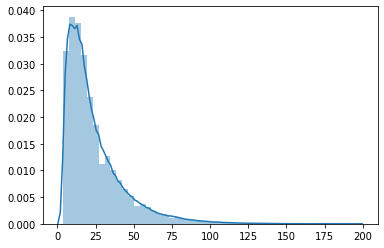

In [10]:
sns.distplot(ds['ga_len']), np.median(ds['ga_len'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8579d918d0>, 17.0)

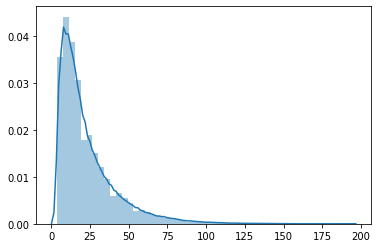

In [11]:
sns.distplot(ds['en_len']), np.median(ds['en_len'])

In [12]:
def len_filter(example,col,l): 
    return example[col] <= l

print(len(ds))
ds = ds.filter(partial(len_filter, col='ga_len', l=60))
ds = ds.filter(partial(len_filter, col='en_len', l=60))
print(len(ds))

355837
334244


In [13]:
# print(f'Removing {len(df.query("en_len > 60"))} EN samples where len was > 60')
# print(len(df))
# df=df[~df.index.isin(df.query("en_len > 60").index)]
# print(len(df))
      
# print(f'Removing {len(df.query("ga_len > 60"))} FR samples where len was > 60')
# print(len(df))
# df=df[~df.index.isin(df.query("ga_len > 60").index)]
# print(len(df))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8579c2a3d0>, 17.0)

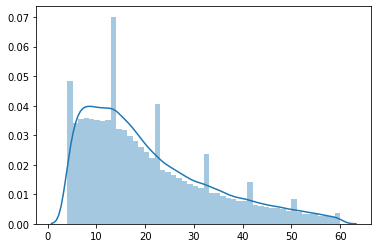

In [14]:
sns.distplot(ds['ga_len']), np.median(ds['ga_len'])

**Lowercase everything**

NOT Done as it is appliced in the rules below

In [15]:
# df['en'] = df['en'].apply(lambda x:x.lower())
# df['ga'] = df['ga'].apply(lambda x:x.lower())

In [16]:
# def lowercase_all(example, lang):
#     example[lang] = example[lang].lower()
#     return example

# ds = ds.map(partial(lowercase_all, lang='ga'))
# ds = ds.map(partial(lowercase_all, lang='en'))
# ds['ga'][400:420]

Rules used as part of tokenization

In [17]:
proc_rules=defaults.text_proc_rules[:-1] + [partial(lowercase, add_eos=True)]
proc_rules

[<function fastai2.text.core.fix_html(x)>,
 <function fastai2.text.core.replace_rep(t)>,
 <function fastai2.text.core.replace_wrep(t)>,
 <function fastai2.text.core.spec_add_spaces(t)>,
 <function fastai2.text.core.rm_useless_spaces(t)>,
 <function fastai2.text.core.replace_all_caps(t)>,
 <function fastai2.text.core.replace_maj(t)>,
 functools.partial(<function lowercase at 0x7f85aac66d40>, add_eos=True)]

### Get Dataloaders

Load vocab to speed up data loading

In [18]:
df=ds.data.to_pandas()
df.head()

,en,ga,clean,ga_len,en_len
0,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True,16,18
1,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",True,18,16
2,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.","I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",True,16,16
3,"As you can see, so get to show off the spacious shapes in 3D (red and blue).","Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",True,21,17
4,"Equation Solving – Traditional, simple","Ligningsløsning – Traidisiúnta, simplí",True,4,5


In [19]:
#df = df.iloc[:1000]

In [20]:
# at 30k tokens per vocab sometimes this works, sometimes it doesn't

# Couldnt process 30k tokens until I added the 'hi' below, it was getting stuck at 94.87%, no idea why
@Numericalize
def encodes(self, o): 
    print('hi')
    return TensorText(tensor([self.o2i  [o_] for o_ in o]))

class floatify_tfm(Transform):
    def encodes(self,o): return o.float()
    def decodes(self,o): return o.long()

max_vocab=30000
#splits = ColSplitter()(df) 
splits = RandomSplitter(valid_pct=0.2, seed=42)(df)

tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)], 
       [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)]]

# tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), 
#          Numericalize(max_vocab=max_vocab), floatify_tfm], 
#        [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"),
#         Numericalize(max_vocab=max_vocab), floatify_tfm]]


dl = partial(SortedDL, shuffle=True, res=df.ga_len.values)

dsets = Datasets(df, tfms, splits=splits, dl_type=dl)

# remove the print from Numericalize
@Numericalize
def encodes(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))

hi


hi


In [21]:
# en_vocab=[]
# ga_vocab=[]
# with open('paracrawl_vocab_en.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         en_vocab.append(row[0])
        
# with open('paracrawl_vocab_ga.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         ga_vocab.append(row[0])
        
#len(en_vocab), len(ga_vocab), en_vocab[:10], ga_vocab[:10]

In [22]:
len(dsets), splits, len(dsets[2][0]), len(dsets[2][1]), dsets[2]

(334244,
 ((#267396) [142788,143864,71475,232172,136743,17163,145516,163557,296155,19037...],
  (#66848) [255414,148963,186606,40380,28590,6799,259930,188378,286014,4807...]),
 24,
 23,
 (TensorText([    2,     8,  1018,     9,     8,  2104,     7,  7176,    11,    16,
            821,    11,    50,    23,   189,   165,  3062,    32,    60,    92,
          19526,  8919,    14,     3]),
  TensorText([    2,    17,   757,    18,     7,  9046,     8,  2425,    10,    17,
            832,    10,    58,    43,    82,   194,  4016,     9,   135, 29410,
           7653,    14,     3])))

In [23]:
bs,sl = 32, 512
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=partial(pad_input, pad_fields=[0,1]))
dls.show_batch()

,text,text_
0,"xxbos ( i ) the application of any goods of a kind specified in the xxmaj fourth xxmaj schedule by a person for the purposes of his business and treated as delivered in accordance with section 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( i ) le duine do bhaint úsáid chun críocha a ghnó as aon earraí de chineál a shonraítear sa xxmaj cheathrú xxmaj sceideal agus a áirítear mar earraí arna seachadadh de réir alt 3 ( 1 ) ( e ) , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
1,xxbos xxmaj it covers all the aspects of developing and managing a successful restaurant business . ” xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,xxbos xxmaj clúdaíonn sé gach uile ghné d’fhorbairt agus do bhainistiú gnó bialainne rathúil . ” xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
2,"xxbos xxmaj helping you prevent heart disease , stroke , diabetes and kidney disease . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos xxmaj ag cabhrú cosc a chur ar ghalar croí tú , stróc , galar diaibéiteas agus duáin . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,xxbos xxmaj what is required therefore ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,xxbos xxmaj cad ata ag teastáil mar sin ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
4,"xxbos ( g ) the xxmaj provincial xxmaj bank of xxmaj ireland , xxmaj limited , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( g ) xxmaj banc xxmaj cúigí na héireann , xxmaj teoranta , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad

Save vocab to speed up data loading

In [24]:
# with open('paracrawl_vocab_en_v0.2_exp2.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[0]:
#         v_writer.writerow([l])
        
# with open('paracrawl_vocab_ga_v0.2_exp2.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[1]:
#         v_writer.writerow([l])

In [25]:
len(dls.train_ds)+len(dls.valid_ds), len(dls.train), len(dls.valid)

(334244, 8356, 2089)

In [26]:
print(f'Vocab lengths are : {len(dls.vocab[0]), len(dls.vocab[1])}')

Vocab lengths are : (22952, 30008)


In [27]:
o=dls.one_batch(); o[0].size(), o[1].size(), o

(torch.Size([32, 71]),
 torch.Size([32, 58]),
 (TensorText([[   2,   13,   57,  ...,    1,    1,    1],
          [   2,    7, 6954,  ...,    1,    1,    1],
          [   2,    8,   50,  ...,    1,    1,    1],
          ...,
          [   2,    8,  686,  ...,    1,    1,    1],
          [   2,   45,   14,  ...,    1,    1,    1],
          [   2,   13,  143,  ...,    1,    1,    1]], device='cuda:0'),
  TensorText([[   2,   12,   17,  ...,    1,    1,    1],
          [   2,    8,   93,  ...,    1,    1,    1],
          [   2,    8, 7226,  ...,    1,    1,    1],
          ...,
          [   2,    8,  653,  ...,    1,    1,    1],
          [   2,   44,   14,  ...,    1,    1,    1],
          [   2,   12,  159,  ...,    1,    1,    1]], device='cuda:0')))

## Transformer model

In [28]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [29]:
# tst_encoding = PositionalEncoding(20)
# res = tst_encoding(torch.arange(0,100).float())
# _, ax = plt.subplots(1,1)
# for i in range(1,5): ax.plot(res[:,i])

In [30]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

## PyTorch Transformer Simple

Note: [src/tgt/memory]_mask should be filled with float(‘-inf’) for the masked positions and float(0.0) else. These masks ensure that predictions for position i depend only on the unmasked positions j and are applied identically for each sequence in a batch. 

[src/tgt/memory]_key_padding_mask should be a ByteTensor where True values are positions that should be masked with float(‘-inf’) and False values will be unchanged. This mask ensures that no information will be taken from position i if it is masked, and has a separate mask for each sequence in a batch.

attn mask with -inf
key_padding mask with True

### pt_Transformer

In [31]:
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [32]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16
        # !!!
        #self.final.weight = self.dec_tfmr_emb.embed.weight    # !! What does this do?
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation='relu', custom_encoder=None, custom_decoder=None)
    
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        #if self.fp16:
        if not isinstance(model.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        
        return out.permute(1,0,2)

In [33]:
# for name, param in model.transformer_model.encoder.layers[0].self_attn.out_proj.named_parameters():
#     print (name)

### Metric

In [34]:
class CorpusBLEUMetric(Metric):
    def __init__(self, vocab_sz=5000, axis=-1):
        """BLEU Metric calculated over the validation corpus"""
        self.pred_len, self.targ_len, self.corrects, self.counts = 0,0,[0]*4,[0]*4
        self.axis, self.vocab_sz = axis, vocab_sz
        
    def reset(self):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
        
    class NGram():
        def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
        def __eq__(self, other):
            if len(self.ngram) != len(other.ngram): return False
            return np.all(np.array(self.ngram) == np.array(other.ngram))
        def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))
    
    def get_grams(self, x, n, max_n=5000):
        return x if n==1 else [self.NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]
    
    def get_correct_ngrams(self, pred, targ, n, max_n=5000):
        pred_grams,targ_grams = self.get_grams(pred, n, max_n=max_n),self.get_grams(targ, n, max_n=max_n)
        pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
        return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)
        
    def accumulate(self, learn):
        last_output = learn.pred.argmax(dim=self.axis)
        last_target = learn.y
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            smooth_mteval = 1
            for i in range(4):
                c,t = self.get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)

                if c == 0:
                    smooth_mteval *= 2
                    c = 1 / smooth_mteval    # exp smoothing, method 3 from http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf
                
                self.corrects[i] += c
                self.counts[i]   += t
        
    @property
    def value(self): 
        if self.counts == 0: return None
        elif max(self.corrects) == 0: return 0.0
        else:
            precs = [c/t for c,t in zip(self.corrects,self.counts)]
            len_penalty = math.exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
            return len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)

### Callbacks

#### Present Input and Target in a single tuple

In [35]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def begin_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

Shifting and masking of y, from [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training):

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

#### Shifting

#### Target shift/offset explained

**Taken from [@bentrevett's brilliant github repo "pytorch-seq2seq" tutorials](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb):**

As we want our model to predict the <eos> token but not have it be an input into our model we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}\text{trg} &= [sos, x_1, x_2, x_3, eos]\\\text{trg[:-1]} &= [sos, x_1, x_2, x_3]\end{align*}$$

$x_i$ denotes **actual** target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes **predicted** target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*} \text{output} &= [y_1, y_2, y_3, eos]\\ \text{trg[1:]} &= [x_1, x_2, x_3, eos] \end{align*}$$

We then calculate our losses and update our parameters as is standard.
    
    
We don't want to punish the model for not translating the 'sos' token, but we do need it to predict/define the end of the sentence

**RemoveEOSCallback** 

Cut the *EOS* token token from the **output_x** presented to the model as we are trying to predict the next word. Therefore don't want to model to try anything after the *EOS* token. So the last token given to the model will be the token before *EOS*. This callback is modifies the second element of our learn.xb, (which is the *copied* yb)

But this should also ignore padding, as otherwise we'll be just cutting the last padding token and not the EOS

In [36]:
class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS. When it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def begin_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

**LossTargetShiftCallback:** Shift the target shown to the loss to exclude the "eos" token, as translating "bos" is not part of our language translation objective

In [37]:
class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

### Model

Transformer size from Annotated Transformer:

N=6, d_model=512, d_ff=2048, h=8

In [38]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 
n_x_vocab, n_y_vocab = len(dls.vocab[0]), len(dls.vocab[1])
d_model=512
n_heads=8 #12
d_inner=2048  #1024

#model = Transformer(n_x_vocab, n_y_vocab, d_model=d_model, n_heads=n_heads, pad_idx=pad_idx)

model=pt_Transformer(src_vcbsz=n_x_vocab, trg_vcbsz=n_y_vocab, d_model=d_model, d_inner=d_inner)

In [39]:
#model

Kaiming_Normal works terrribly, at least if you apply it to everything except LayerNorm...

DistilBERT works ok

Could try xavier:

```
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
```

**DistilBERT initialisation**

In [40]:
# DistilERT HF init weights https://github.com/huggingface/transformers/blob/31e67dd19f1b3fe2bc9a13f86d814f3f7bba48e4/src/transformers/modeling_distilbert.py

def distil_apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)


def _distilbert_init_weights(module):
    """ Initialize the weights.
    """
    if isinstance(module, nn.Embedding):
        if module.weight.requires_grad:
            module.weight.data.normal_(mean=0.0, std=0.02) #std=self.config.initializer_range)
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02) #self.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

distil_apply_leaf(model, _distilbert_init_weights)

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 86,650,168 trainable parameters


### Learner

In [43]:
cbs = [CombineInputOutputCallback, RemoveEOSCallback(eos_idx=3), LossTargetShiftCallback]

pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

loss_func = CrossEntropyLossFlat(ignore_index=pad_idx)

learn = Learner(dls, model, metrics=[accuracy, Perplexity(), CorpusBLEUMetric(vocab_sz=n_y_vocab)], 
                cbs=cbs, loss_func=loss_func).to_fp16()

# learn = Learner(dls, model, metrics=[accuracy, Perplexity()],
#                 cbs=cbs, loss_func=loss_func).to_fp16()

# Training

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

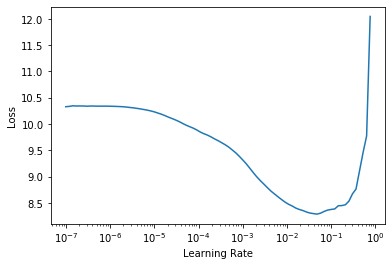

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(15, 5e-4, div=15, pct_start=0.15)

epoch,train_loss,valid_loss,accuracy,perplexity,corpus_bleu,time
0,1.737470,1.735670,0.505868,5.672728,0.341238,14:19
1,1.314091,1.349056,0.544238,3.853786,0.390208,14:36
2,1.083588,1.149825,0.569437,3.157641,0.426192,14:29
3,0.930475,1.080131,0.576922,2.945066,0.440672,14:55
4,0.834824,1.014957,0.586565,2.759245,0.455232,14:56
5,0.750972,0.963366,0.594916,2.620502,0.468841,14:25
6,0.678620,0.958166,0.595461,2.606910,0.474195,15:06
7,0.616270,0.924851,0.602025,2.521493,0.485946,14:42
8,0.509049,0.877889,0.608430,2.405816,0.495998,15:05
9,0.442716,0.870553,0.610859,2.388231,0.503087,14:40


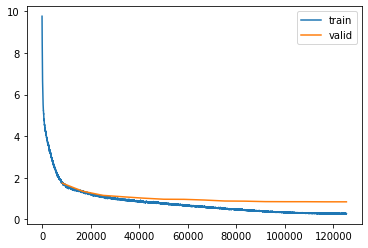

In [46]:
learn.recorder.plot_loss()

In [47]:
learn.save('paracrawl_en_ga_5e_5e-4_v0.2_exp6')

### Testing

In [48]:
t_path = Path('data/irish/parallel_corpora/tatoeba')
t_fn = 'tatoeba_en-ga.csv'
t_df = pd.read_csv(t_path/t_fn)

t_df['ga_len'] = t_df.ga.str.split().str.len()
t_df.head()

,ga_id,ga,en_id,en,ga_len
0,557291,Cá bhfuil críochfort na mbus?,35406,Where is the bus terminal?,5
1,557299,"Nuair a dhúisigh mé, bhí brón orm.",1361,"When I woke up, I was sad.",7
2,557533,Tosaíonn an t-oideachas sa bhaile.,19122,Education starts at home.,5
3,557579,Táim i ngrá leat.,1434,I love you.,4
4,934942,Tá grá agam duit.,1434,I love you.,4


In [49]:
# # at 30k tokens per vocab sometimes this works, sometimes it doesn't

# # Couldnt process 30k tokens until I added the 'hi' below, it was getting stuck at 94.87%, no idea why
# @Numericalize
# def encodes(self, o): 
#     print('hi')
#     return TensorText(tensor([self.o2i  [o_] for o_ in o]))

# class floatify_tfm(Transform):
#     def encodes(self,o): return o.float()
#     def decodes(self,o): return o.long()

# max_vocab=30000
# #splits = ColSplitter()(df) 
# #splits = RandomSplitter(valid_pct=0.2, seed=42)(t_df)
# splits = [list(range(len(t_df))),list(range(len(t_df)))]

# # tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), 
# #          Numericalize(max_vocab=max_vocab, vocab=dls.vocab[0])], 
# #        [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"), 
# #         Numericalize(max_vocab=max_vocab, vocab=dls.vocab[1])]]

# tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), 
#          Numericalize(max_vocab=max_vocab, vocab=dls.vocab[0])],[]] 

# #t_dl = partial(SortedDL, shuffle=True, res=t_df.ga_len.values)

# t_dsets = Datasets(t_df, tfms, splits=splits, dl_type=SortedDL)

# # remove the print from Numericalize
# @Numericalize
# def encodes(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))

# # Create Dataloaders
# #t_dls = t_dsets.dataloaders(bs=bs, seq_len=sl, before_batch=partial(pad_input, pad_fields=[0,1]))
# t_dls = t_dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_input) # partial(pad_input, pad_fields=[0]))
# t_dls.show_batch()

In [50]:
# learn.dls.test_dl = t_dls.valid
# def act_fn(x): return L(F.softmax(o, dim=-1) for o in x)
# o = learn.get_preds(dl=t_dls.valid, act=act_fn)

In [49]:
def generate(model, sentence, vocab):
    #model = torch.load('output/transformer.pth')
#     lang_model = spacy.load('en')
#     with open('data/processed/en/freq_list.pkl', 'rb') as f:
#         en_freq_list = pickle.load(f)
#     with open('data/processed/fr/freq_list.pkl', 'rb') as f:
#         fr_freq_list = pickle.load(f)
    #sentence = input('Please enter your english sentence: ')
    #sentence = tokenize(sentence, en_freq_list, lang_model)
    
    model=model.eval()
    
    sentence=learn.dls.tokenizer[0][1].encodes(sentence)
    sentence=learn.dls.numericalize[0].encodes(sentence)
    
    translated_sentence = [2] # xxbos
    #translated_sentence = [fr_freq_list['[SOS]']]
    i = 0
    while int(translated_sentence[-1]) != 3 and i < 75:   # xxeos
    #while int(translated_sentence[-1]) != fr_freq_list['[EOS]'] and i < 15:
        #output = forward_model(model, sentence, translated_sentence).to('cuda')
        output = forward_model(model, sentence, translated_sentence).cuda()
        values, indices = torch.topk(output, 5)
        translated_sentence.append(int(indices[-1][0]))
        i+=1

    detok_translated_sentence=detokenize(translated_sentence, vocab)
    #print(' '.join(detok_translated_sentence))
    return ' '.join(detok_translated_sentence)
    

def forward_model(model, src, tgt):
    src = torch.as_tensor(src).unsqueeze(0).long().cuda()
    tgt = torch.as_tensor(tgt).unsqueeze(0).cuda()
    tgt_mask = gen_nopeek_mask(tgt.shape[1]).cuda()
    src = to_half(src)
    tgt = to_half(tgt)
    output = model.forward(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)

    #return output.squeeze(0).to('cpu')
    return output.squeeze(0).detach()


# def tokenize(sentence, freq_list, lang_model):
#     punctuation = ['(', ')', ':', '"', ' ']

#     sentence = sentence.lower()
#     sentence = [tok.text for tok in lang_model.tokenizer(sentence) if tok.text not in punctuation]
#     return [freq_list[word] if word in freq_list else freq_list['[OOV]'] for word in sentence]


def detokenize(sentence, vocab):
    #freq_list = {v: k for k, v in freq_list.items()}
    return [vocab[token] for token in sentence]
    #return [freq_list[token] for token in sentence]
# def detokenize(sentence, freq_list):
#     freq_list = {v: k for k, v in freq_list.items()}
#     return [freq_list[token] for token in sentence]


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [50]:
def process_trans(trans):
    trans_ls=[]
    for s in trans: 
        #print(s)
        tmp = s.replace('xxbos','')
        tmp = tmp.replace('xxeos','')
        tmp = tmp.replace(' .','.')
        tmp = tmp.replace(' ,',',')
        tmp = tmp.replace(' ?','?')
        tmp = tmp.replace(' !','!')
        #print(tmp[0])
        if tmp.endswith('. '): tmp=tmp[:-1]
        if tmp.endswith('? '): tmp=tmp[:-1]
        if tmp.endswith('! '): tmp=tmp[:-1]
        
        for spec in ['xxmaj ', 'xxup ']:
            found=[]
            for m in re.finditer(spec, tmp):
                found.append(m.start())

            for f in found:
                m = tmp.find(spec)
                if m != -1:   
                    ml = m+len(spec)
                    if m != 0:
                        tmp = tmp[:ml] + tmp[ml].upper() + tmp[ml+1:]
                        tmp = tmp[:m] + tmp[ml:]
                    else: 
                        tmp = tmp[ml].upper() + tmp[ml+1:]
                        tmp = tmp[ml:]
        
        # Remove space at start
        if tmp[0] == ' ': tmp = tmp[1:]
            
        # Uppercase start of sentence
        #tmp = tmp[0].upper() + tmp[1:]
            
        trans_ls.append(tmp)
    return trans_ls

Generate translations

In [51]:
generate(learn.model, "I'm ready for the weekend!", dls.vocab[1])

'xxbos xxup tá mé réidh don deireadh seachtaine ! xxeos'

In [52]:
trans_ls=[]
for e in t_df.en.values:
    trans_ls.append(generate(learn.model, e, dls.vocab[1]))    
trans_ls[:5]

['xxbos i gcás gurb é an críochfort bus ? xxeos',
 'xxbos xxmaj nuair a xxunk mé suas , bhí mé brónach . xxeos',
 'xxbos xxmaj tosaíonn an t - oideachas sa bhaile . xxeos',
 'xxbos xxmaj grá dom leat . xxeos',
 'xxbos xxmaj grá dom leat . xxeos']

In [53]:
f=open('tatoeba_raw_translations_exp6_20200724.txt','w')
for ele in trans_ls:
    f.write(ele+'\n')
f.close()

In [54]:
f=open('tatoeba_raw_translations_exp6_20200724.txt','w')
for ele in trans_ls:
    f.write(ele+'\n')
f.close()

Process translations

In [55]:
t_final = process_trans(trans_ls)
t_final[:8]

['i gcás gurb é an críochfort bus?',
 'Nuair a xxunk mé suas, bhí mé brónach.',
 'Tosaíonn an t - oideachas sa bhaile.',
 'Grá dom leat.',
 'Grá dom leat.',
 'Tá mé i ngrá le leat.',
 'Glan ár seomra ranga tar éis na scoile.',
 'Nach bhfuil bhuail dúinn roimh?']

In [56]:
f=open('tatoeba_processed_translations_exp6_20200724.txt','w')
for ele in t_final:
    f.write(ele+'\n')
f.close()

In [57]:
t_df['translation'] = t_final
t_df.to_csv('tatoeba_with_translation_exp6_20200724.csv')

In [58]:
t_df[['ga','translation']].sample(20)

,ga,translation
688,Tá an focal faire gearr.,Is é an pasfhocal gearr. Is é an pasfhocal xxunk.
654,Tá sibh ag léamh.,Tá tú ag léamh.
894,Oibreoidh sí.,Oibreoidh sí í. Oibreoidh sí í.
133,Ghearr sé é leis an scian a fuair sé mar bronntanas óna dheartháir.,Ghearradh sé leis an scian go bhfuair sé mar bhronntanas óna dheartháir.
1341,B'fhearr liom colscaradh a fháil.,Ba mhaith liom a fearr le colscaradh a fháil.
302,Rugadh i Meiriceá mé.,Rugadh i Meiriceá. Rugadh mé i Meiriceá.
1842,Gan dabht.,Níl amhras. gan amhras.
1014,Tá trucail agam.,Tá mé trucail.
345,Beidh sé ag cur sneachta amárach.,Beidh sé sneachta amárach.
1796,Tá mé ábalta é sin a dhéanamh anois,Tá mé in ann a dhéanamh go anois


## SacreBLEU

In [59]:
import sacrebleu

refs = [t_df.ga.values.tolist()]
sys = t_df.translation.values.tolist()

bleu = sacrebleu.corpus_bleu(sys, refs)
print(bleu.score)

21.25902031648537


## 5e results

In [63]:
generate(learn.model, "hello, how are you?", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [64]:
generate(learn.model, "Can you tell we where the bus station is please?", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [65]:
generate(learn.model, "Yesterday it rained, but tomorrow will be very sunny", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [66]:
generate(learn.model, "I had a great day, my translator is working", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [67]:
generate(learn.model, "So this is a story all about how my lift got flip turned \
upside down, so I'd like to take a minute just sit right there, I'll you all about how I became the fresh prince\
of belair", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [68]:
generate(learn.model, "dog", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [69]:
generate(learn.model, "cat", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [70]:
generate(learn.model, "tree", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [71]:
generate(learn.model, "building", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [72]:
generate(learn.model, "city", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [73]:
generate(learn.model, "woman", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [74]:
generate(learn.model, "man", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [75]:
generate(learn.model, "chocolate", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [76]:
generate(learn.model, "spaceship", dls.vocab[1])

'xxbos xxmaj an xxmaj chéad xxmaj lch. xxmaj lch. xxmaj roimhe xxmaj seo ( cuid xxup ii . xxmaj custaim agus xxmaj mál . ) xxeos'

In [ ]:
# https://forums.fast.ai/t/fastai-v2-text/53529/334
from fastai2.text.all import *

defaults.device = torch.device('cpu')
path = Path('.')
learner = load_learner("./export.pkl")

f = open("/tmp/test.txt", "r")
test_file_contents = f.read()

_, _, losses = learner.predict(test_file_contents)
cats = [learner.dls.categorize.decode(i) for i in range(len(losses))]

predictions = sorted(
    zip(cats, map(float, losses)),
    key=lambda p: p[1],
    reverse=True
)
print(predictions)

# OR

items = pd.read_csv("/tmp/test.txt", sep = '\t')
test_dl = learner.dls.test_dl(items.values)

learner.get_preds(dl=test_dl, with_decoded=False)